--- Resumo dos Clusters ---
         frequencia_compras  total_gasto  media_passagens  qtd_clientes
cluster                                                                
0                  2.251083   231.440972         1.221917         68304
1                  1.000007   120.979179         1.000007        149450
2                  2.032950   604.243951         1.755838         41123
3                  1.028738   208.572156         2.085064         75614


--- Gerando Gráficos de Dispersão 2D ---


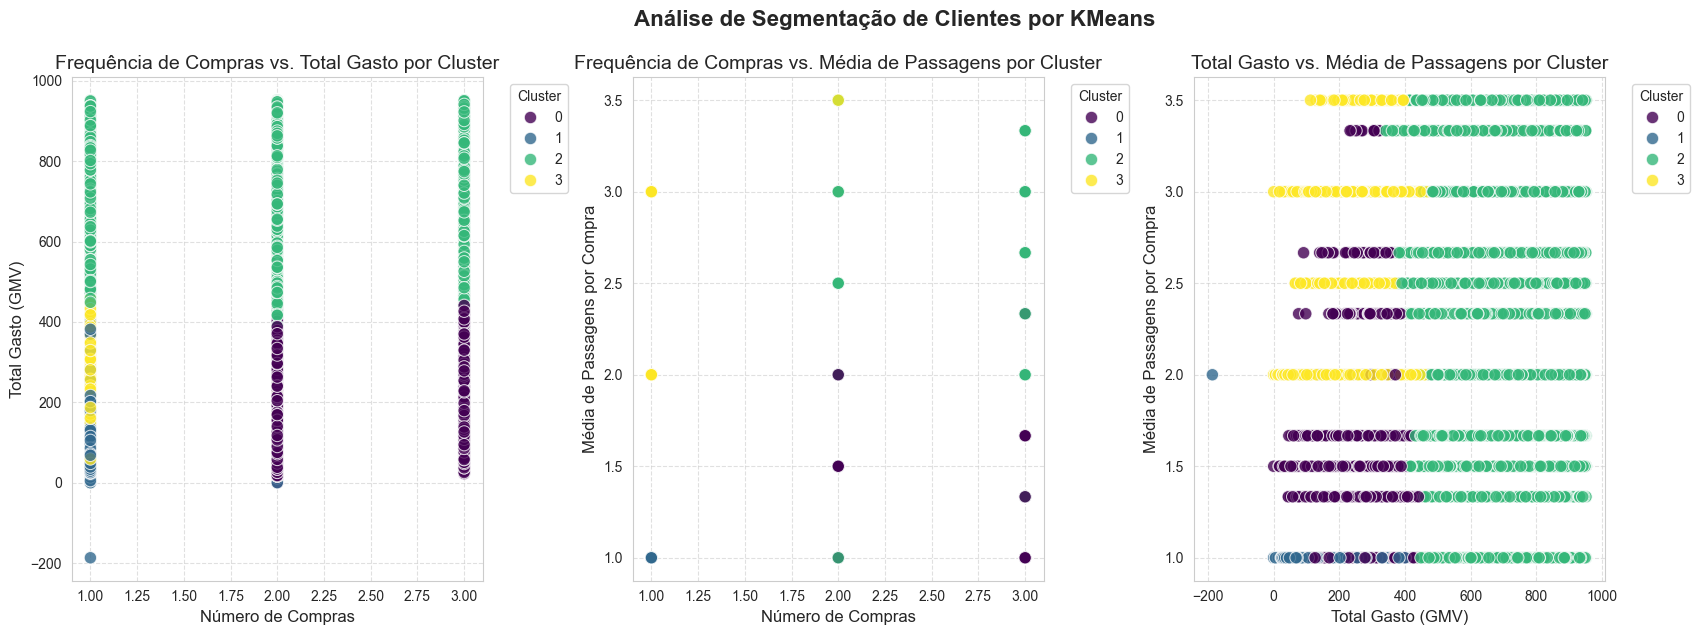

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. CARREGAR SEUS DADOS ---
df_clientes = pd.read_csv(r"C:\Users\polly\Downloads\challenge\df_t.csv")

# --- 2. ENGENHARIA DE FEATURES (Criando as variáveis para segmentação) ---

# Converter 'date_purchase' para datetime para facilitar agregações se necessário
df_clientes['date_purchase'] = pd.to_datetime(df_clientes['date_purchase'])

# Calcular 'total_gasto' (gmv_success) por cliente
# Agrupamos por 'fk_contact' (ID do cliente) para ter as métricas por cliente
df_agregado = df_clientes.groupby('fk_contact').agg(
    total_gasto=('gmv_success', 'sum'), # Soma do GMV para cada cliente
    frequencia_compras=('date_purchase', 'count'), # Número de compras por cliente
    media_passagens=('total_tickets_quantity_success', 'mean') # Média de passagens por compra de cada cliente
).reset_index()

# Selecionar as colunas para o clustering
dados = df_agregado[["frequencia_compras", "total_gasto", "media_passagens"]].copy()

# Remover outliers com base no IQR
Q1 = dados.quantile(0.25)
Q3 = dados.quantile(0.75)
IQR = Q3 - Q1
dados_sem_outliers = dados[~((dados < (Q1 - 1.5 * IQR)) | (dados > (Q3 + 1.5 * IQR))).any(axis=1)]

# --- 3. NORMALIZAR DADOS ---
scaler = RobustScaler()
dados_normalizados = scaler.fit_transform(dados_sem_outliers)

# --- 4. APLICAR KMEANS ---
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
df_segmentado = dados_sem_outliers.copy()
df_segmentado["cluster"] = kmeans.fit_predict(dados_normalizados)

# --- 5. VER PERFIL MÉDIO DE CADA CLUSTER (RESUMO) ---
resumo = df_segmentado.groupby("cluster").agg({
    "frequencia_compras": "mean",
    "total_gasto": "mean",
    "media_passagens": "mean",
    "cluster": "count"
}).rename(columns={"cluster": "qtd_clientes"})

print("--- Resumo dos Clusters ---")
print(resumo)
print("\n")


# --- 6. GERAR GRÁFICOS 2D PARA ANÁLISE ---
print("--- Gerando Gráficos de Dispersão 2D ---")

sns.set_style("whitegrid")

plt.figure(figsize=(18, 6))

# Gráfico 1: Frequência de Compras vs. Total Gasto
plt.subplot(1, 3, 1)
sns.scatterplot(data=df_segmentado, x="frequencia_compras", y="total_gasto",
                hue="cluster",
                palette="viridis",
                s=80,
                alpha=0.8)
plt.title("Frequência de Compras vs. Total Gasto por Cluster", fontsize=14)
plt.xlabel("Número de Compras", fontsize=12)
plt.ylabel("Total Gasto (GMV)", fontsize=12)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

# Gráfico 2: Frequência de Compras vs. Média de Passagens
plt.subplot(1, 3, 2)
sns.scatterplot(data=df_segmentado, x="frequencia_compras", y="media_passagens",
                hue="cluster",
                palette="viridis",
                s=80,
                alpha=0.8)
plt.title("Frequência de Compras vs. Média de Passagens por Cluster", fontsize=14)
plt.xlabel("Número de Compras", fontsize=12)
plt.ylabel("Média de Passagens por Compra", fontsize=12)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

# Gráfico 3: Total Gasto vs. Média de Passagens
plt.subplot(1, 3, 3)
sns.scatterplot(data=df_segmentado, x="total_gasto", y="media_passagens",
                hue="cluster",
                palette="viridis",
                s=80,
                alpha=0.8)
plt.title("Total Gasto vs. Média de Passagens por Cluster", fontsize=14)
plt.xlabel("Total Gasto (GMV)", fontsize=12)
plt.ylabel("Média de Passagens por Compra", fontsize=12)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.suptitle("Análise de Segmentação de Clientes por KMeans", y=1.05, fontsize=16, weight='bold')
plt.show()

C:\Users\polly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


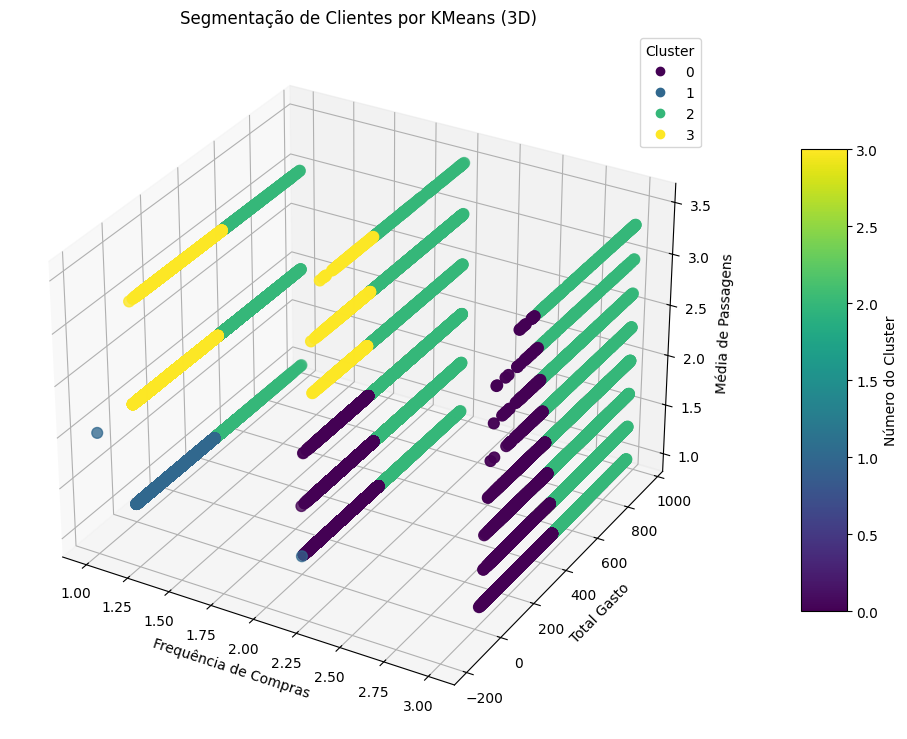

C:\Users\polly\AppData\Local\Temp\ipykernel_13088\3358316870.py:48: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\polly\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


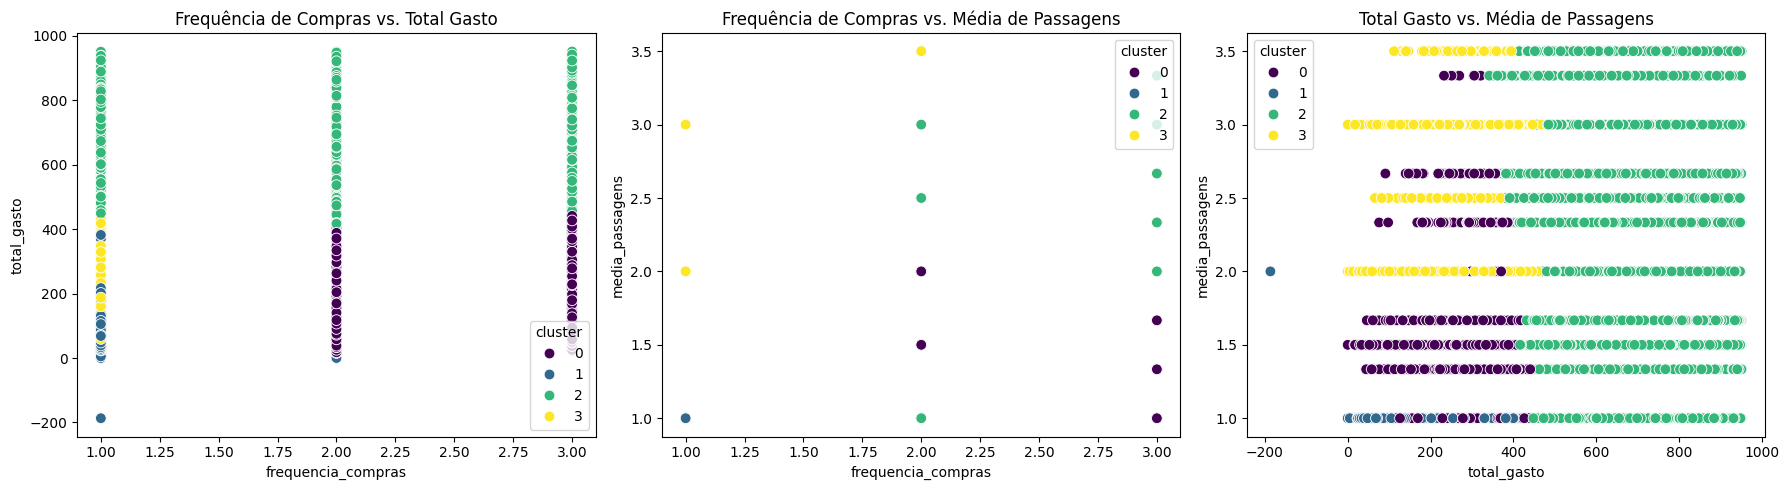

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Criação da figura e eixos 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Definindo as colunas para o gráfico
x = df_segmentado["frequencia_compras"]
y = df_segmentado["total_gasto"]
z = df_segmentado["media_passagens"]
colors = df_segmentado["cluster"]

# Criação do scatter plot 3D
scatter = ax.scatter(x, y, z, c=colors, cmap='viridis', s=60)

# Rótulos dos eixos
ax.set_xlabel("Frequência de Compras")
ax.set_ylabel("Total Gasto")
ax.set_zlabel("Média de Passagens")

# Título do gráfico
ax.set_title("Segmentação de Clientes por KMeans (3D)")

# Legenda para os clusters
legend = ax.legend(*scatter.legend_elements(), title="Cluster")
plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.6, aspect=10, label="Número do Cluster")

# Exibir o gráfico
plt.show()

# --- Gráficos de dispersão 2D para cada par de variáveis ---
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=df_segmentado, x="frequencia_compras", y="total_gasto", hue="cluster", palette="viridis", s=60)
plt.title("Frequência de Compras vs. Total Gasto")

plt.subplot(1, 3, 2)
sns.scatterplot(data=df_segmentado, x="frequencia_compras", y="media_passagens", hue="cluster", palette="viridis", s=60)
plt.title("Frequência de Compras vs. Média de Passagens")

plt.subplot(1, 3, 3)
sns.scatterplot(data=df_segmentado, x="total_gasto", y="media_passagens", hue="cluster", palette="viridis", s=60)
plt.title("Total Gasto vs. Média de Passagens")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Importado para o np.random.choice

# --- 1. CARREGAR SEUS DADOS ---
# Usando o caminho e o nome do arquivo que você forneceu
df_clientes = pd.read_csv(r"C:\Users\polly\Downloads\challenge\df_t.csv")

# --- 2. ENGENHARIA DE FEATURES (Criando as variáveis para segmentação) ---

# Converter 'date_purchase' para datetime
df_clientes['date_purchase'] = pd.to_datetime(df_clientes['date_purchase'])

# Agrupar por 'fk_contact' (ID do cliente) para ter as métricas por cliente
df_agregado = df_clientes.groupby('fk_contact').agg(
    total_gasto=('gmv_success', 'sum'), # Soma do GMV para cada cliente
    frequencia_compras=('date_purchase', 'count'), # Número de compras por cliente
    media_passagens=('total_tickets_quantity_success', 'mean') # Média de passagens por compra de cada cliente
).reset_index()

# Selecionar as colunas para o clustering
dados = df_agregado[["frequencia_compras", "total_gasto", "media_passagens"]].copy()

# Remover outliers com base no IQR
Q1 = dados.quantile(0.25)
Q3 = dados.quantile(0.75)
IQR = Q3 - Q1
dados_sem_outliers = dados[~((dados < (Q1 - 1.5 * IQR)) | (dados > (Q3 + 1.5 * IQR))).any(axis=1)]

# --- 3. NORMALIZAR DADOS ---
scaler = RobustScaler()
dados_normalizados = scaler.fit_transform(dados_sem_outliers)

# --- 4. APLICAR KMEANS ---
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
df_segmentado = dados_sem_outliers.copy()
df_segmentado["cluster"] = kmeans.fit_predict(dados_normalizados)

# Adicionar o fk_contact de volta ao df_segmentado para poder selecionar clientes
# É crucial que o 'fk_contact' esteja presente para selecionar um cliente por ID
# e também para buscar as rotas originais no df_clientes.
# Vamos mesclar com df_agregado que já tem o fk_contact e as métricas calculadas.
# A coluna 'cluster' já está em df_segmentado, então vamos mesclar pelo índice
# para garantir que os clusters estejam alinhados corretamente com os clientes do df_agregado.

# Primeiro, garantir que dados_sem_outliers tem o fk_contact para o merge correto.
# Isso garante que o df_segmentado final tenha o fk_contact do cliente original.
df_segmentado_com_id = df_agregado.loc[dados_sem_outliers.index].copy()
df_segmentado_com_id['cluster'] = df_segmentado['cluster'] # Copia os clusters para o DF com ID

# Agora, df_segmentado_com_id é o nosso df_segmentado final com fk_contact e cluster
df_segmentado = df_segmentado_com_id


# --- 5. VER PERFIL MÉDIO DE CADA CLUSTER (RESUMO) ---
# Este resumo deve ser o mesmo de antes, mas é bom ter para referência
resumo = df_segmentado.groupby("cluster").agg({
    "frequencia_compras": "mean",
    "total_gasto": "mean",
    "media_passagens": "mean",
    "cluster": "count"
}).rename(columns={"cluster": "qtd_clientes"})

print("--- Resumo dos Clusters ---")
print(resumo)
print("\n")


# --- CÓDIGO PARA SELECIONAR CLIENTE E ANALISAR ---

print("\n--- Análise de Cliente Individual do Cluster 1 ---\n")

# Filtra clientes que estão no Cluster 1
clientes_cluster_1 = df_segmentado[df_segmentado['cluster'] == 1]

if not clientes_cluster_1.empty:
    # Seleciona um cliente aleatório do Cluster 1
    # random_state usado para reprodutibilidade, mude o número para pegar outro cliente
    cliente_exemplo = clientes_cluster_1.sample(1, random_state=42).iloc[0]

    cliente_id = cliente_exemplo['fk_contact']
    freq_compras = cliente_exemplo['frequencia_compras'] # AGORA SEM '_original'
    total_gasto = cliente_exemplo['total_gasto']         # AGORA SEM '_original'
    media_passagens = cliente_exemplo['media_passagens'] # AGORA SEM '_original'

    print(f"Cliente Selecionado (ID): {cliente_id}")
    print(f"Cluster ao qual pertence: {cliente_exemplo['cluster']}")
    print("\n--- Perfil de Compra Histórico ---")
    print(f"Frequência de Compras (no período total dos dados): {freq_compras:.2f} compras")
    print(f"Total Gasto (no período total dos dados): R$ {total_gasto:.2f}")
    print(f"Média de Passagens por Compra: {media_passagens:.2f} passagens")

    print("\n--- Inferências e Sugestões (Baseadas no perfil do Cluster 1) ---")
    print("Considerando que este cliente pertence ao Cluster 1 ('Compradores de Primeira Viagem'),")
    print(f"que tem uma frequência média de {freq_compras:.2f} e gasto médio de R$ {total_gasto:.2f}:")

    print("\n* **Próxima Compra na Plataforma (em 30 dias):**")
    print("    A probabilidade de este cliente realizar uma nova compra nos próximos 30 dias é **baixa**,")
    print("    dado o histórico de apenas uma compra no período total dos dados. Eles tendem a ser esporádicos.")
    print("    É fundamental um estímulo direto para reengajamento.")

    print("\n* **Rota Potencial:**")
    # Para rotas, vamos pegar as rotas compradas por este cliente no df_clientes original
    rotas_anteriores = df_clientes[df_clientes['fk_contact'] == cliente_id][['place_origin_departure', 'place_destination_departure']].drop_duplicates()

    if not rotas_anteriores.empty:
        print("    Historicamente, este cliente comprou as seguintes rotas:")
        for index, row in rotas_anteriores.iterrows():
            print(f"    - Origem: {row['place_origin_departure']} -> Destino: {row['place_destination_departure']}")
        print("    Para a próxima compra, podemos sugerir essas rotas novamente ou rotas similares.")
    else:
        # Isso pode acontecer se o cliente foi removido pelos outliers ou se o fk_contact
        # não se alinha perfeitamente entre o df_segmentado e df_clientes.
        # Para um cliente específico do Cluster 1, é mais provável que só tenha uma entrada,
        # então o drop_duplicates não faria diferença.
        print("    Não foi possível identificar rotas anteriores para este cliente específico no df_clientes original.")
        print("    Como cliente de primeira viagem, podemos sugerir rotas populares para novos usuários ou destinos estratégicos para seu negócio.")

    print("\n* **Estratégia Recomendada para este Cliente:**")
    print("    Este cliente se beneficiaria de campanhas de reativação para primeira compra,")
    print("    incentivos para a segunda compra (ex: desconto exclusivo) e conteúdo educacional")
    print("    que promova o turismo e a descoberta de novos destinos e as facilidades da plataforma.")

else:
    print("Não foram encontrados clientes no Cluster . Isso pode indicar que o clustering não gerou esse cluster")
    print("ou que o DataFrame 'df_segmentado' está vazio ou não contém a coluna 'cluster' corretamente.")

--- Resumo dos Clusters ---
         frequencia_compras  total_gasto  media_passagens  qtd_clientes
cluster                                                                
0                  2.251083   231.440972         1.221917         68304
1                  1.000007   120.979179         1.000007        149450
2                  2.032950   604.243951         1.755838         41123
3                  1.028738   208.572156         2.085064         75614



--- Análise de Cliente Individual do Cluster 1 ---

Cliente Selecionado (ID): 4444ef7b51fa39e9f5ab81a745607591877bd4e6dfd3f4e9cfda1134c9c7d4f5
Cluster ao qual pertence: 1

--- Perfil de Compra Histórico ---
Frequência de Compras (no período total dos dados): 1.00 compras
Total Gasto (no período total dos dados): R$ 40.24
Média de Passagens por Compra: 1.00 passagens

--- Inferências e Sugestões (Baseadas no perfil do Cluster 1) ---
Considerando que este cliente pertence ao Cluster 1 ('Compradores de Primeira Viagem'),
que tem uma f